In [1]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 22.9 MB/s eta 0:00:0000:01


In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import skfuzzy as fuzz
from sklearn.metrics import jaccard_score
from glob import glob

In [3]:
BASE_PATH = "/kaggle/input/datasets/jeetblahiri/bccd-dataset-with-mask/BCCD Dataset with mask"

TRAIN_IMG_PATH = os.path.join(BASE_PATH, "train", "original")
TRAIN_MASK_PATH = os.path.join(BASE_PATH, "train", "mask")

TEST_IMG_PATH = os.path.join(BASE_PATH, "test", "original")
TEST_MASK_PATH = os.path.join(BASE_PATH, "test", "mask")

train_images = sorted(glob(os.path.join(TRAIN_IMG_PATH, "*")))
train_masks  = sorted(glob(os.path.join(TRAIN_MASK_PATH, "*")))

test_images = sorted(glob(os.path.join(TEST_IMG_PATH, "*")))
test_masks  = sorted(glob(os.path.join(TEST_MASK_PATH, "*")))

print("Train Images:", len(train_images))
print("Train Masks :", len(train_masks))
print("Test Images :", len(test_images))
print("Test Masks  :", len(test_masks))

Train Images: 1169
Train Masks : 1169
Test Images : 159
Test Masks  : 159


In [4]:
def preprocess(img_path, mask_path, size=(256,256)):
    
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size)

    mask = cv2.imread(mask_path, 0)
    mask = cv2.resize(mask, size)
    
    # Convert to binary mask
    mask = (mask > 0).astype(np.uint8)

    return img, mask

In [5]:
def kmeans_segmentation(img, k=3):
    
    pixels = img.reshape((-1,3))
    pixels = np.float32(pixels)
    
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixels)
    
    segmented = labels.reshape(img.shape[:2])
    return segmented

In [6]:
def fcm_segmentation(img, c=3):
    
    pixels = img.reshape((-1,3)).T
    pixels = np.float64(pixels)
    
    cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
        pixels, c=c, m=2, error=0.005, maxiter=300
    )
    
    labels = np.argmax(u, axis=0)
    segmented = labels.reshape(img.shape[:2])
    
    return segmented

In [7]:
def compute_iou(pred, gt):
    return jaccard_score(gt.flatten(), pred.flatten())

In [8]:
# Combine full dataset
all_images = train_images + test_images
all_masks  = train_masks + test_masks

print("Total Images in Full Dataset:", len(all_images))

kmeans_scores = []
fcm_scores = []

for i in range(len(all_images)):
    
    img, mask = preprocess(all_images[i], all_masks[i])
    
    # ----- KMEANS -----
    k_seg = kmeans_segmentation(img)
    best_iou_k = 0
    
    for cluster_id in np.unique(k_seg):
        candidate = (k_seg == cluster_id).astype(np.uint8)
        score = compute_iou(candidate, mask)
        if score > best_iou_k:
            best_iou_k = score
            
    kmeans_scores.append(best_iou_k)
    
    
    # ----- FCM -----
    f_seg = fcm_segmentation(img)
    best_iou_f = 0
    
    for cluster_id in np.unique(f_seg):
        candidate = (f_seg == cluster_id).astype(np.uint8)
        score = compute_iou(candidate, mask)
        if score > best_iou_f:
            best_iou_f = score
            
    fcm_scores.append(best_iou_f)
    
    
    # Progress update
    if (i+1) % 20 == 0:
        print(f"Processed {i+1}/{len(all_images)} images")

Total Images in Full Dataset: 1328
Processed 20/1328 images
Processed 40/1328 images
Processed 60/1328 images
Processed 80/1328 images
Processed 100/1328 images
Processed 120/1328 images
Processed 140/1328 images
Processed 160/1328 images
Processed 180/1328 images
Processed 200/1328 images
Processed 220/1328 images
Processed 240/1328 images
Processed 260/1328 images
Processed 280/1328 images
Processed 300/1328 images
Processed 320/1328 images
Processed 340/1328 images
Processed 360/1328 images
Processed 380/1328 images
Processed 400/1328 images
Processed 420/1328 images
Processed 440/1328 images
Processed 460/1328 images
Processed 480/1328 images
Processed 500/1328 images
Processed 520/1328 images
Processed 540/1328 images
Processed 560/1328 images
Processed 580/1328 images
Processed 600/1328 images
Processed 620/1328 images
Processed 640/1328 images
Processed 660/1328 images
Processed 680/1328 images
Processed 700/1328 images
Processed 720/1328 images
Processed 740/1328 images
Process

In [9]:
print("\n===== FULL DATASET RESULTS =====")
print("Total Images Evaluated:", len(all_images))
print("----------------------------------")
print("K-Means Average IoU :", np.mean(kmeans_scores))
print("FCM Average IoU     :", np.mean(fcm_scores))


===== FULL DATASET RESULTS =====
Total Images Evaluated: 1328
----------------------------------
K-Means Average IoU : 0.6215944011857963
FCM Average IoU     : 0.5998822028018678


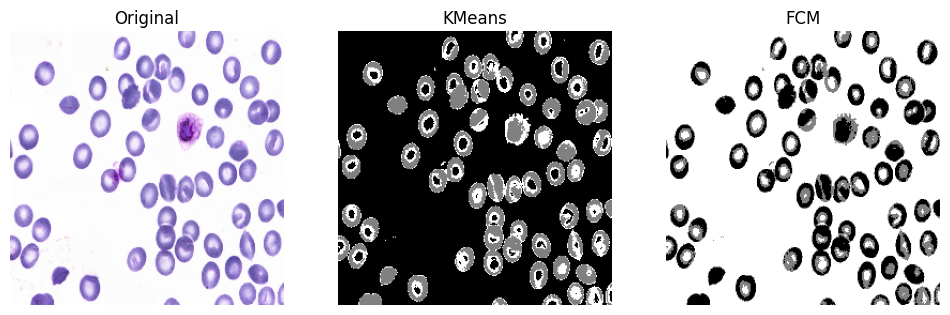

In [10]:
img, mask = preprocess(all_images[0], all_masks[0])

k_seg = kmeans_segmentation(img)
f_seg = fcm_segmentation(img)

plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(img)
plt.title("Original")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(k_seg, cmap="gray")
plt.title("KMeans")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(f_seg, cmap="gray")
plt.title("FCM")
plt.axis("off")

plt.show()